In [1]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

repo_dir = Path().resolve().parent
sys.path.append(str(repo_dir))

data_dir = repo_dir / "data"

In [2]:
zip_path = data_dir / "predict-student-performance-from-game-play.zip"

if not zip_path.exists():
    !kaggle competitions download -c predict-student-performance-from-game-play -p {data_dir}
    !unzip -o {zip_path} -d {data_dir}

In [3]:
train_df = pd.read_csv(data_dir / "train.csv")
test_df = pd.read_csv(data_dir / "test.csv")
train_labels_df = pd.read_csv(data_dir / "train_labels.csv")

In [4]:
train_df

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13174206,22100221145014656,1600,5483231,navigate_click,undefined,22,NaN,343.887291,36.701026,483.0,273.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22
13174207,22100221145014656,1601,5485166,navigate_click,undefined,22,NaN,332.696070,141.493178,545.0,221.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22
13174208,22100221145014656,1602,5485917,navigate_click,undefined,22,NaN,369.912859,140.569205,611.0,217.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22
13174209,22100221145014656,1603,5486753,navigate_click,undefined,22,NaN,252.299653,123.805889,526.0,232.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22


In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   session_id      10000 non-null  int64  
 1   index           10000 non-null  int64  
 2   elapsed_time    10000 non-null  int64  
 3   event_name      10000 non-null  object 
 4   name            10000 non-null  object 
 5   level           10000 non-null  int64  
 6   page            268 non-null    float64
 7   room_coor_x     8830 non-null   float64
 8   room_coor_y     8830 non-null   float64
 9   screen_coor_x   8830 non-null   float64
 10  screen_coor_y   8830 non-null   float64
 11  hover_duration  1144 non-null   float64
 12  text            3383 non-null   object 
 13  fqid            6816 non-null   object 
 14  room_fqid       10000 non-null  object 
 15  text_fqid       3383 non-null   object 
 16  fullscreen      0 non-null      float64
 17  hq              0 non-null      

In [21]:
train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212022 entries, 0 to 212021
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   session_id  212022 non-null  object
 1   correct     212022 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ MB


## Data Exploration

#### Objective

The objective of this competition is to use time series data generated by an online educational game to determine whether players will answer questions correctly. There are three question checkpoints (level 4, level 12, and level 22), each with a number of questions. At each checkpoint, you will have access to all previous test data for that section.


#### Files

- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format
- train_labels.csv - correct value for all 18 questions for each session in the training set

#### Columns

- session_id - the ID of the session the event took place in
- index - the index of the event for the session
- elapsed_time - how much time has passed (in milliseconds) between the start of the session and when the event was recorded
- event_name - the name of the event type
- name - the event name (e.g. identifies whether a notebook_click is is opening or closing the notebook)
- level - what level of the game the event occurred in (0 to 22)
- page - the page number of the event (only for notebook-related events)
- room_coor_x - the coordinates of the click in reference to the in-game room (only for click events)
- room_coor_y - the coordinates of the click in reference to the in-game room (only for click events)
- screen_coor_x - the coordinates of the click in reference to the player’s screen (only for click events)
- screen_coor_y - the coordinates of the click in reference to the player’s screen (only for click events)
- hover_duration - how long (in milliseconds) the hover happened for (only for hover events)
- text - the text the player sees during this event
- fqid - the fully qualified ID of the event
- room_fqid - the fully qualified ID of the room the event took place in
- text_fqid - the fully qualified ID of the
- fullscreen - whether the player is in fullscreen mode
- hq - whether the game is in high-quality
- music - whether the game music is on or off
- level_group - which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)

[EDA example](https://www.kaggle.com/code/nguyenthicamlai/eda-ml-on-game-play-ongoing)

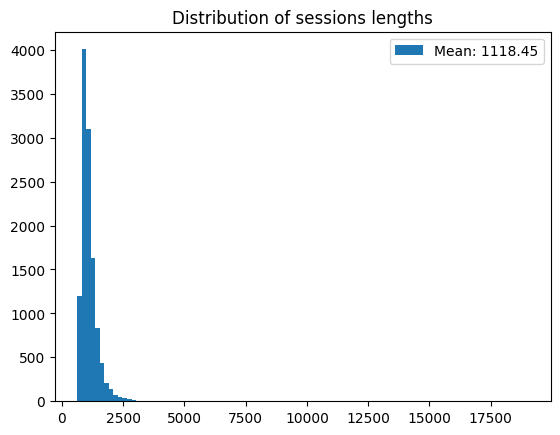

In [9]:
sessions_lens = train_df['session_id'].value_counts().values
plt.hist(sessions_lens, bins=100, label=f'Mean: {np.mean(sessions_lens):.2f}')
plt.legend()
plt.title('Distribution of sessions lengths');

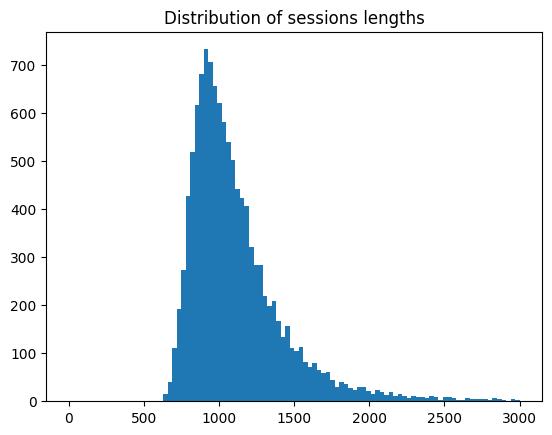

In [15]:
plt.hist(sessions_lens, bins=100, range=(0, 3000))
plt.title('Distribution of sessions lengths');

In [12]:
sampled_session = train_df['session_id'].sample(1).values[0]
sampled_session_df = train_df[train_df['session_id'] == sampled_session]
sampled_session_df

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
6735428,21040312514866840,0,0,cutscene_click,basic,0,NaN,61.223653,-124.050950,943.328125,506.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
6735429,21040312514866840,1,2997,cutscene_click,basic,0,NaN,11.361016,-31.578422,888.328125,404.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
6735430,21040312514866840,2,4768,cutscene_click,basic,0,NaN,-9.490633,-8.913587,865.328125,379.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
6735431,21040312514866840,3,5424,person_click,basic,0,NaN,2.295082,9.218281,878.328125,359.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
6735432,21040312514866840,4,6193,person_click,basic,0,NaN,44.904972,-102.292708,925.328125,482.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6737231,21040312514866840,1877,2161906,navigate_click,undefined,1,NaN,-617.501350,-21.260017,318.328125,355.0,NaN,NaN,retirement_letter,tunic.historicalsociety.closet,NaN,NaN,NaN,NaN,0-4
6737232,21040312514866840,1878,2171732,notification_click,basic,1,NaN,-837.676214,-182.817286,123.328125,536.0,NaN,Gramps is in trouble for losing papers?,NaN,tunic.historicalsociety.closet,tunic.historicalsociety.closet.retirement_lett...,NaN,NaN,NaN,0-4
6737233,21040312514866840,1879,2172091,notification_click,basic,1,NaN,-855.808083,-180.097505,103.328125,533.0,NaN,This can't be right!,NaN,tunic.historicalsociety.closet,tunic.historicalsociety.closet.retirement_lett...,NaN,NaN,NaN,0-4
6737234,21040312514866840,1880,2172330,notification_click,basic,1,NaN,-868.500391,-181.004099,89.328125,534.0,NaN,Gramps is the best historian ever!,NaN,tunic.historicalsociety.closet,tunic.historicalsociety.closet.retirement_lett...,NaN,NaN,NaN,0-4
